In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import os
from urllib.request import urlretrieve
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE


Il dataset preso in considerazione contiene informazioni utili per la predizione di infarti. Il dataset contiene le informazioni di 5000 pazienti, per ognuno di essi è specificato se hanno avuto un'infarto (stroke = 1) o no (stroke = 0), l'obbiettivo è predire questa variabile discreta

In [2]:
def download(file, url):
    if not os.path.isfile(file):
        urlretrieve(url, file)

In [3]:
download("strokes.csv", "https://raw.githubusercontent.com/giacomoaccursi/progettoDataIntensive/main/healthcare-dataset-stroke-data.csv")

In [4]:
data = pd.read_csv("strokes.csv")

1. id: identificatore unico
2. gender: il genere della persone. "Male", "Female" or "Other"
3. age: l'età del paziente
4. hypertension: 0 se il paziente non soffre di ipertensione, 1 se ne soffre
5. heart_disease: 0 se il paziente non ha malattie cardiache, 1 se ne ha
6. ever_married: "No" se non si è mai sposato o "Yes" altrimenti
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" se vive in campagna o "Urban" se vive in città
9. avg_glucose_level: livello medio di glucosio nel sangue
10. bmi: indice di massa corporea, rapporto fra peso e quadrato dell'altezza
11. smoking_status: "formerly smoked" se ha fumato in precedenza, "never smoked" se non ha mai fumato, "smokes" se fuma attualmente o "Unknown" se il dato è sconosciuto
12. stroke: 1 se il paziente ha avuto un infarto, 0 altrimenti. 

Essendo la variabile stroke discreta, siamo di fronte ad un problema di classificazione con due classi. 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


La variabile id identifica univocamente il paziente. Non è quindi utile nella predizione. Può essere usata come indice della riga.

In [6]:
data.set_index('id', inplace=True)

In [7]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Rinominiamo la colonna Residence_type cosicchè tutte le feature abbiano la prima lettera minuscola

In [8]:
data.rename(columns={'Residence_type': 'residence_type'}, inplace=True)

In [9]:
data['ever_married'] = data["ever_married"].replace({'No' : 0, 'Yes' : 1})

In [10]:
data.describe()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,0.656164,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,0.475034,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,1.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,1.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,1.000000,271.740000,97.600000,1.000000


+ L'età media dei pazienti è circa 43 anni, il più giovane ha meno di un anno e il più anziano ne ha 42. Il 50% degli esaminati ha più di 45 anni. 

In [11]:
(data.describe(exclude = ['float', 'int64']))

,gender,work_type,residence_type,smoking_status
count,5110,5110,5110,5110
unique,3,5,2,4
top,Female,Private,Urban,never smoked
freq,2994,2925,2596,1892


In un secondo momento occorrerà trattare i valori bmi nulli

In [12]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

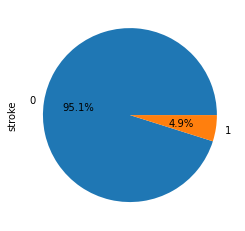

In [13]:
data['stroke'].value_counts().plot.pie(autopct='%1.1f%%'); 

Si noti come il dataset risulti fortemente sbilanciato: il numero di persone che hanno avuto un infarto è nettamente inferiore a quelle che non l'hanno avuto. Nelle fasi successive si cercherà di risolvere questo problema

# Data Exploration

Circa il 60% delle persone in esame sono donne. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



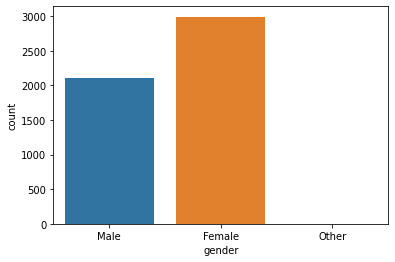

In [14]:
sns.countplot(data['gender']);

Sembra che il sesso non influisca sulla probabilità di avere un infarto.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



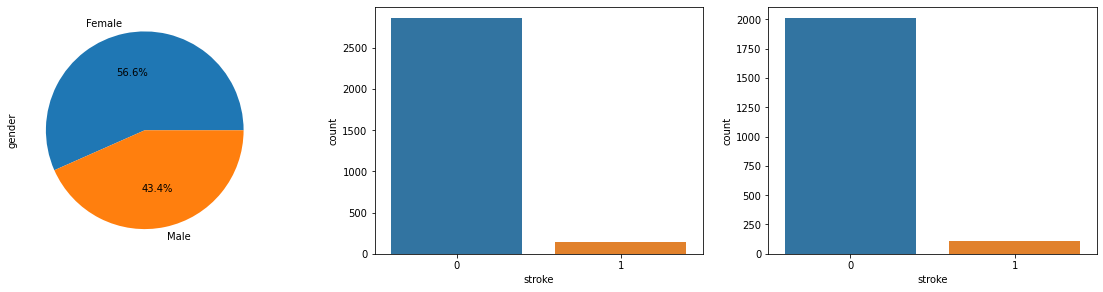

In [15]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
(data[data["stroke"] == 1]["gender"]).value_counts().plot.pie(autopct='%1.1f%%'); 
plt.subplot(2, 3, 2)
sns.countplot((data[data["gender"] == "Female"]["stroke"]))
plt.subplot(2, 3, 3)
sns.countplot((data[data["gender"] == "Male"]["stroke"]))
fig.show()

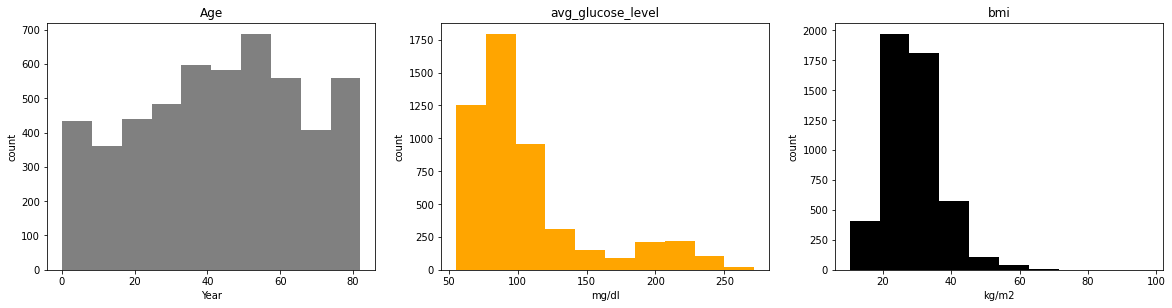

In [16]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.title('Age')
plt.hist(data['age'], label="weight", color='gray')
plt.ylabel('count')
plt.xlabel('Year')


plt.subplot(2, 3, 2)
plt.title('avg_glucose_level')
plt.hist(data['avg_glucose_level'], label="weight", color="orange")
plt.ylabel('count')
plt.xlabel('mg/dl')

plt.subplot(2, 3, 3)
plt.title('bmi')
plt.hist(data['bmi'], label="weight", color="black")
plt.ylabel('count')
plt.xlabel('kg/m2')

plt.show()

In [17]:
((data["bmi"] > 25) & (data["bmi"] < 30)).mean()

0.27045009784735813

In [18]:
(data["bmi"] > 30).mean()

0.3704500978473581

Non è specificato se i valori di glucosio nel sangue siano stati rilevati a digiuno o dopo 120' dal carico orale di glucosio. 
Secondo l'indicatore bmi il 27% delle persone in esame risulti sovrappesa e il 37% obesa, si noti però che il bmi non è un buon indicatore per il fatto che tiene in considerazione solo l'altezza in relazione al peso senza considerare la percentuale di grasso corporeo.

Valori glicemici a digiuno: 
+ Normale : 80-99 mg/dl
+ Alterata : 100-125 mg/dl
+ DIabete : >126


Valori glicemici dopo 120' dal carico orale di glucosio: 
+ Normale : <140 mg/dl
+ Alterata : 140-200 mg/dl
+ DIabete : >200


valori bmi: 
+ Sottopeso : <18.5
+ Normale : 18.5 - 24.9
+ Sovrappeso : 25- 29.9
+ Obeso : >30

SI noti come per valori bmi superiori a 30 la probabilità di avere infarti aumenti leggermente e come livelli di glucosio superiori a 150 corrispondano ad un numero maggiore di infarti.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/di

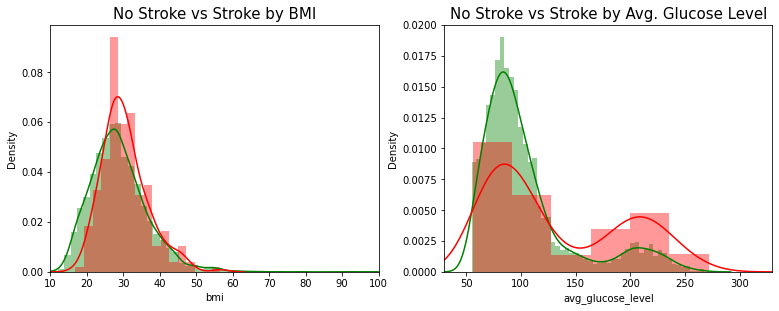

In [19]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
sns.distplot(data[data['stroke'] == 0]["bmi"], color='green') # No Stroke - green
sns.distplot(data[data['stroke'] == 1]["bmi"], color='red') # Stroke - Red

plt.title('No Stroke vs Stroke by BMI', fontsize=15)
plt.xlim([10,100])

plt.subplot(2, 3, 2)
sns.distplot(data[data['stroke'] == 0]["avg_glucose_level"], color='green') # No Stroke - green
sns.distplot(data[data['stroke'] == 1]["avg_glucose_level"], color='red') # Stroke - Red

plt.title('No Stroke vs Stroke by Avg. Glucose Level', fontsize=15)
plt.xlim([30,330])
plt.show()

Dal seguente istogramma emerge come le persone che sono state o sono sposate abbiamo una probabilità maggiore di avere un infarto, tuttavia questo è molto probabilmente causato dal fatto che le persone sposate o che sono state sposate hanno un'età maggiore delle persone che non si sono sposate. 

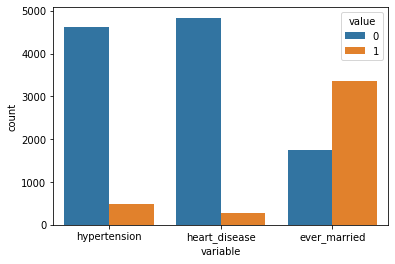

In [20]:
sns.countplot(x="variable", hue="value", data= pd.melt(data.loc[:, ['hypertension', 'heart_disease', 'ever_married']]));

Dal seguente scatterplot si nota come gli infarti sono più diffusi nelle persone in età avanzata e con livelli di glucosio alti.

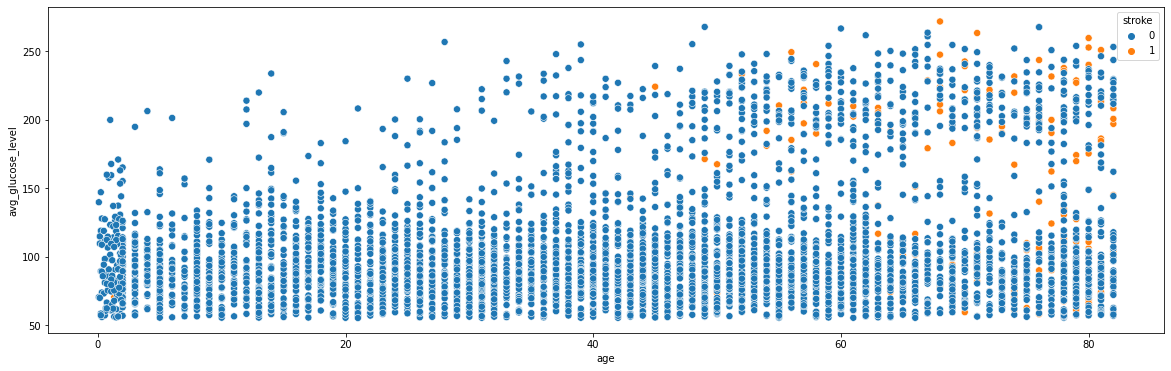

In [21]:
fig = plt.gcf()
fig.set_size_inches(20, 6)
sns.scatterplot(x=data['age'],y=data['avg_glucose_level'],hue=data['stroke'], s=50); 

Come previsto il numero di infarti è maggiore nelle persone più anziane.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



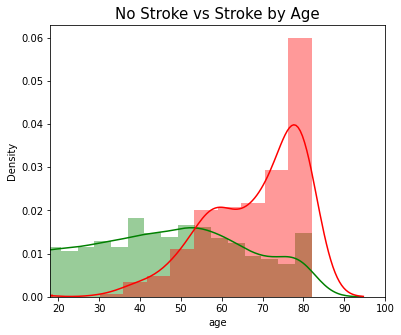

In [22]:
plt.figure(figsize=(6,5))

sns.distplot(data[data['stroke'] == 0]["age"], color='green') # No Stroke - green
sns.distplot(data[data['stroke'] == 1]["age"], color='red') # Stroke - Red

plt.title('No Stroke vs Stroke by Age', fontsize=15)
plt.xlim([18,100])
plt.show()

Il numero di infarti è maggiore nelle persone che non hanno mai fumato rispetto a quelle che hanno fumato o fumano tuttora. Ricordiamoci comunque che del 30% del dataset in questione non abbiamo informazioni. 

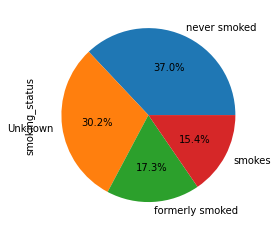

In [23]:
data['smoking_status'].value_counts().plot.pie(autopct='%1.1f%%'); 

Non sembra che ci siano lavori che influenzano la probabilità di avere un infarto

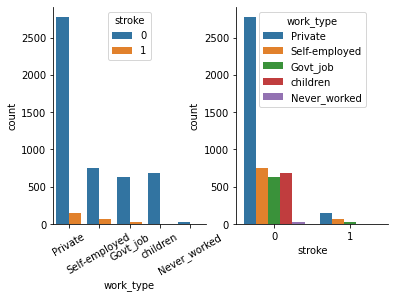

In [24]:
plt.subplot(1, 2, 1)

sns.countplot(x='work_type', hue='stroke', data=data)
plt.xticks(rotation=30)
sns.despine()

plt.subplot(1, 2, 2)
sns.countplot(x='stroke', hue='work_type', data=data)
sns.despine()

plt.show()

Lo stesso discorso vale per la residenza delle persone: vivere in città o in campagna non sembra rilevante

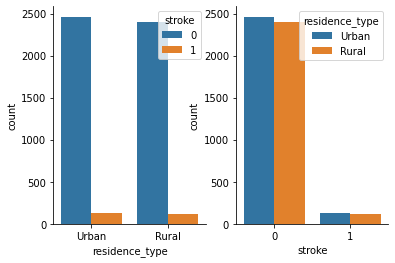

In [25]:
plt.subplot(1, 2, 1)

sns.countplot(x='residence_type', hue='stroke', data=data)
sns.despine()

plt.subplot(1, 2, 2)
sns.countplot(x='stroke', hue='residence_type', data=data)
sns.despine()

plt.show()

I seguenti istogrammi evidenziano come problemi al cuore e ipertensione aumentino la probabilità di avere un infarto

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



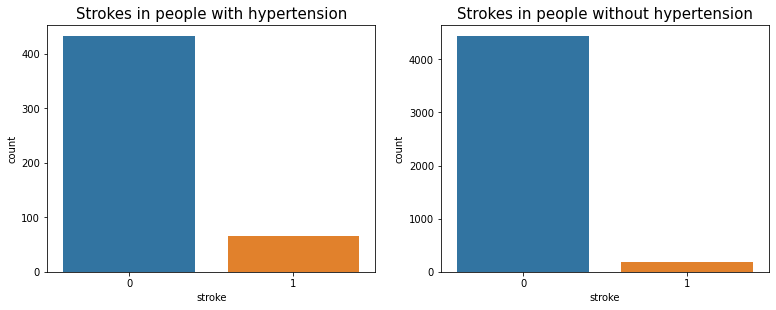

In [26]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
plt.title('Strokes in people with hypertension', fontsize=15)
sns.countplot((data[data["hypertension"] == 1]["stroke"]))
plt.subplot(2, 3, 2)
plt.title('Strokes in people without hypertension', fontsize=15)
sns.countplot((data[data["hypertension"] == 0]["stroke"]))
fig.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



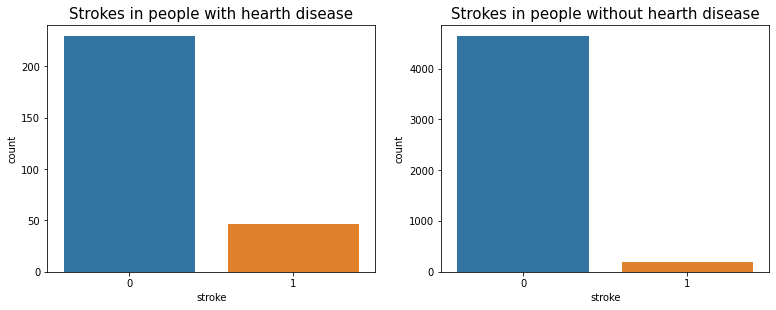

In [27]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 1)
plt.title('Strokes in people with hearth disease', fontsize=15)
sns.countplot((data[data["heart_disease"] == 1]["stroke"]))
plt.subplot(2, 3, 2)
plt.title('Strokes in people without hearth disease', fontsize=15)
sns.countplot((data[data["heart_disease"] == 0]["stroke"]))
fig.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t

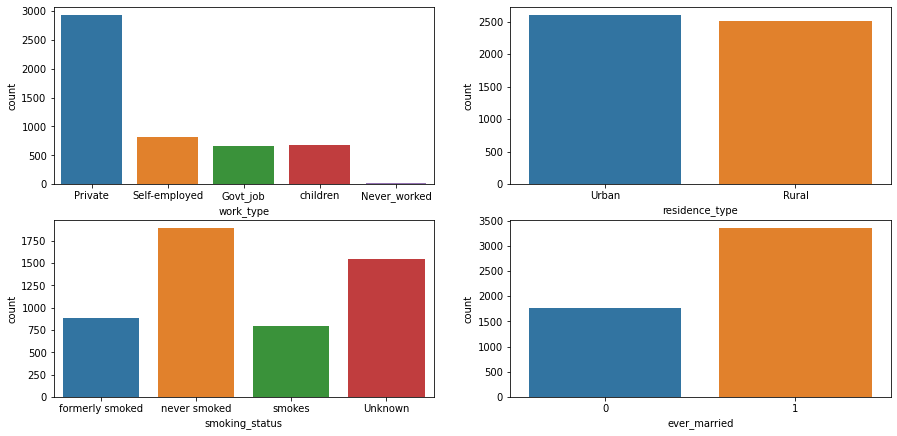

In [28]:
plt.figure(figsize=(15, 15))
plt.subplot(4,2,1)
sns.countplot(data['work_type'])
plt.subplot(4,2,2)
sns.countplot(data['residence_type'])
plt.subplot(4,2,3)
sns.countplot(data['smoking_status'])
plt.subplot(4,2,4)
sns.countplot(data['ever_married'])

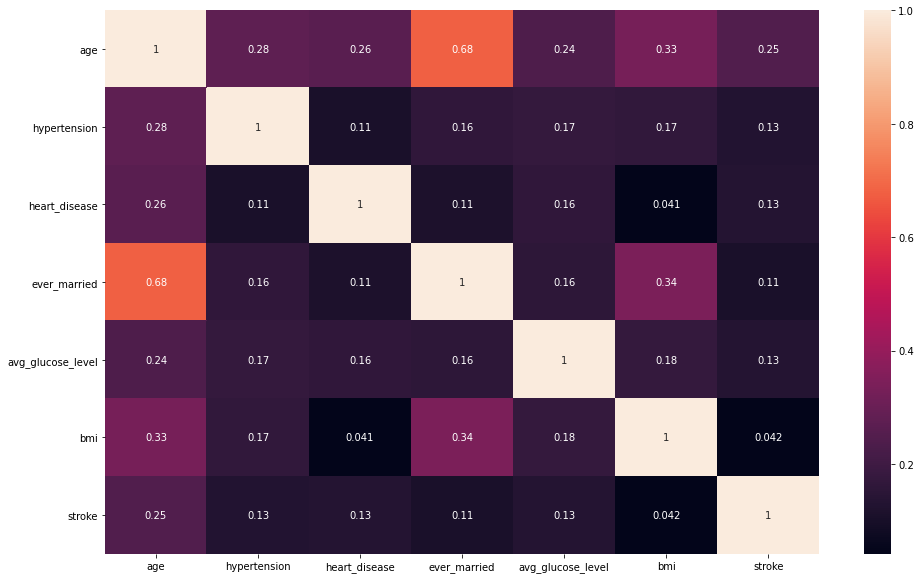

In [29]:
plt.figure(figsize=(16,10))
sns.heatmap(data.corr(method='pearson'), annot=True); 

Come ipotizzato in precedenza esiste una correlazione abbastanza forte fra l'età e il numero di persone sposate.
 

# Feature engineering

In [30]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Elimiamo i record con ibm nullo

In [31]:
data.dropna(inplace=True)

In [32]:
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [33]:
data["age"] = data["age"].astype(int)
data["avg_glucose_level"] = data["avg_glucose_level"].astype(int)
data["bmi"] = data["bmi"].astype(int)

Il dataset risulta fortemente sbilanciato, creiamo quindi nuovi record.
E' stato utilizzato SMOTENC al posto di SMOTE poichè è più indicato nei casi in cui si hanno sia variaibili categoriche che numeriche

In [34]:
categorical_features = ["gender", "work_type", "residence_type", "smoking_status"]
data = pd.get_dummies(data, columns=categorical_features, prefix=categorical_features)

In [35]:
data

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,,,,,,,
9046,67,0,1,1,228,36,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0
31112,80,0,1,1,105,32,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0
60182,49,0,0,1,171,34,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1
1665,79,1,0,1,174,24,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0
56669,81,0,0,1,186,29,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14180,13,0,0,0,103,18,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0
44873,81,0,0,1,125,40,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0
19723,35,0,0,1,82,30,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0


In [36]:
sm = SMOTE(random_state=42)
y = data["stroke"]
X = data.drop("stroke", axis=1)
X, y = sm.fit_resample(X, y)


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



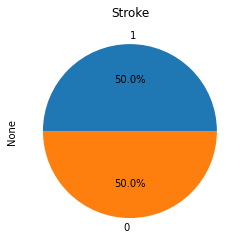

In [37]:
pd.value_counts(y).plot.pie(autopct="%.1f%%", title="Stroke");

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import precision_score, recall_score, f1_score


In [38]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [39]:
X_train, X_val, y_train, y_val = train_test_split(
    X,y,
    test_size = 1/3,
    random_state = 42
)

In [40]:
models = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [41]:
def accuracy_interval(f):
  N = len(y_val)
  n_min = f + ( 1.96**2/(2*N) - 1.96 * np.sqrt( (f/N) - (f**2/N) + (1.96**2/(4*N**2) ) ) ) 
  n_max = f + ( 1.96**2/(2*N) + 1.96 * np.sqrt( (f/N) - (f**2/N) + (1.96**2/(4*N**2) ) ) ) 
  d = 1 + (1.96**2 / N)
  e_min = n_min / d
  e_max = n_max / d
  return np.round(e_min,4), np.round(e_max,4)

In [43]:
from sklearn.linear_model import Perceptron

std_perceptron = Perceptron(n_jobs=-1, early_stopping=True, n_iter_no_change=5)

parameters = {
    'penalty': [None, 'l1', 'l2', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 1],
    'tol': [1e-9, 1e-6, 1e-3, 1, 1e3, 1e6],
}

perceptron_cv = GridSearchCV(std_perceptron, parameters, cv=kf, n_jobs=-1)
perceptron_cv.fit(X_train, y_train)

print('Best parameters:', perceptron_cv.best_params_)  

models["Perceptron"] = {"Model": perceptron_cv.best_estimator_ , "Score" : perceptron_cv.score}

Best parameters: {'alpha': 0.0001, 'penalty': 'l1', 'tol': 1e-09}


In [44]:
poly_perceptron = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('perceptron', Perceptron(n_jobs=-1, early_stopping=True, n_iter_no_change=5))
])

parameters = {
    'perceptron__penalty': ['l1', 'l2'],
    'perceptron__alpha': [0.0001, 0.001, 0.01],
    'perceptron__tol': [1e-9, 1e-6, 1e-3, 1],
}

poly_perceptron_cv = GridSearchCV(poly_perceptron, parameters, cv=kf, n_jobs=-1, return_train_score=True)
poly_perceptron_cv.fit(X_train, y_train)

print('Best parameters:', poly_perceptron_cv.best_params_)  

models["Perceptron"] = {"Model": perceptron_cv.best_estimator_ , "Score" : poly_perceptron_cv.score}

Best parameters: {'perceptron__alpha': 0.0001, 'perceptron__penalty': 'l1', 'perceptron__tol': 1e-09}


In [45]:
from sklearn.linear_model import LogisticRegression

std_lr = LogisticRegression(solver="saga", random_state=42)
grid = [
    {
        "penalty": ["l2", "l1"],
        "C": [0.1, 1, 10], 
        "tol" : [1e-9, 1e-6, 1e-3, 1e-2, 1e-1, 1]
    },
    {
        "penalty": ["elasticnet"],
        "C": [0.1, 1, 10],
        "l1_ratio": [0.2, 0.5],
        "tol" : [1e-9, 1e-6, 1e-3, 1e-2, 1e-1, 1]
    }
]

lr_gs = GridSearchCV(std_lr, grid, cv=kf, n_jobs=-1, return_train_score=True)
lr_gs.fit(X_train, y_train)

print('Best parameters:', lr_gs.best_params_)  

models["Logistic Regression"] = {"Model": lr_gs.best_estimator_ , "Score" : lr_gs.score}

Best parameters: {'C': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'tol': 0.01}


In [46]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier(n_jobs=-1)
grid = {
        'n_neighbors': range(1, 10, 1),
        'weights': ['uniform', 'distance']
}

knc_gs = GridSearchCV(knc, grid, cv=kf, n_jobs=-1, return_train_score=True)
knc_gs.fit(X_train, y_train)

print('Best parameters:', knc_gs.best_params_)  

models["KNeighborsClassifier"] = {"Model": knc_gs.best_estimator_ , "Score" : knc_gs.score}

Best parameters: {'n_neighbors': 2, 'weights': 'uniform'}


In [47]:
from sklearn.svm import SVC
std_svm = SVC()

grid = {
    'kernel': ['rbf'],
    'C': [0.01, 0.1, 1],
}

svm_gs = GridSearchCV(std_svm, grid, cv=kf, n_jobs=-1, return_train_score=True)
svm_gs.fit(X_train, y_train)

print('Best parameters:', lr_gs.best_params_)  

models["Support Vector Machine"] = {"Model": svm_gs.best_estimator_ , "Score" : svm_gs.score}

Best parameters: {'C': 0.1, 'l1_ratio': 0.5, 'penalty': 'elasticnet', 'tol': 0.01}


In [48]:
from sklearn.tree import DecisionTreeClassifier

d_tree = DecisionTreeClassifier(random_state=42)

grid = {
             'min_samples_split': range(2, 4, 1),
             'min_samples_leaf': range(1, 4, 1), 
             'max_depth': [None] + [i for i in range(2, 7)],
             'max_features': range(2, data.columns.size, 1)}


d_tree = GridSearchCV(d_tree, grid, cv=kf, n_jobs=-1, return_train_score=True)
d_tree.fit(X_train, y_train)

print('Best parameters:', d_tree.best_params_)  

models["Decision Tree"] = {"Model": d_tree.best_estimator_ , "Score" : d_tree.score}

Best parameters: {'max_depth': None, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [49]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1, random_state=3)

grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
}
    

rfc_gs = GridSearchCV(rfc, grid, cv=kf, n_jobs=-1, return_train_score=True)
rfc_gs.fit(X_train, y_train)

print('Best parameters:', rfc_gs.best_params_)  

models["Random Forest"] = {"Model": rfc_gs.best_estimator_ , "Score" : rfc_gs.score}

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [50]:
from xgboost import XGBClassifier

std_xgb = XGBClassifier(nthread=8, objective='binary:logistic')

parameters = {
    'xgb__eta': [0.002, 0.1, 0.5],
    'xgb__min_child_weight': [4, 10],
    'xgb__max_depth': [6],
    'xgb__n_estimators': [150, 300],
    'xgb__alpha': [0.0001, 0.001]
}

xgb_gs = GridSearchCV(std_xgb, parameters, cv=kf, n_jobs=-1, return_train_score=True)
xgb_gs.fit(X_train, y_train)

print('Best parameters:', xgb_gs.best_params_)  

models["XGBoost"] = {"Model": xgb_gs.best_estimator_ , "Score" : xgb_gs.score}

Best parameters: {'xgb__alpha': 0.0001, 'xgb__eta': 0.002, 'xgb__max_depth': 6, 'xgb__min_child_weight': 4, 'xgb__n_estimators': 150}


In [51]:
from sklearn.dummy import DummyClassifier
random = DummyClassifier(strategy="uniform", random_state=42)
random.fit(X_train, y_train)

models["Random"] = {"Model": random , "Score" : random.score}

# Model Comparison

In [52]:
for name, model in models.items():
  model = models[name]
  y_pred = model["Model"].predict(X_val)
  print(name)
  model["Precision"] = precision_score(y_val, y_pred, pos_label=0)
  model["Recall"] = recall_score(y_val, y_pred, pos_label=0)
  model["F1_Score"] = f1_score(y_val, y_pred, average="macro")
  model["mse"] = mean_squared_error(y_val, y_pred)
  print("Precision = ", model["Precision"])
  print("Recall = ", model["Recall"])
  print("F1 score = ", model["F1_Score"])
  print( pd.DataFrame(confusion_matrix(y_val, y_pred), index=["No Stroke", "Stroke"], columns=["No Stroke", "Stroke"]))
  print("Accuracy interval = ", accuracy_interval(model["F1_Score"]))
  print("MSE = ", model["mse"])
  print("\n\n")

Perceptron
Precision =  0.9225268176400476
Recall =  0.9754253308128544
F1 score =  0.9459809205597873
           No Stroke  Stroke
No Stroke       1548      39
Stroke           130    1417
Accuracy interval =  (0.9375, 0.9534)
MSE =  0.053924696873005745



Logistic Regression
Precision =  0.9233918128654971
Recall =  0.9949590422180214
F1 score =  0.9555274334745528
           No Stroke  Stroke
No Stroke       1579       8
Stroke           131    1416
Accuracy interval =  (0.9477, 0.9622)
MSE =  0.04435226547543076



KNeighborsClassifier
Precision =  0.9503331314354937
Recall =  0.9886578449905482
F1 score =  0.9680567191987883
           No Stroke  Stroke
No Stroke       1569      18
Stroke            82    1465
Accuracy interval =  (0.9613, 0.9737)
MSE =  0.03190810465858328



Support Vector Machine
Precision =  0.9262295081967213
Recall =  0.9968494013862634
F1 score =  0.9580897781602455
           No Stroke  Stroke
No Stroke       1582       5
Stroke           126    1421
Accu

Confrontiamo con una confidenza del 95% i modelli, dati i rispettivi errori. 

In [54]:
from itertools import combinations

def intervall95(mse1, mse2, confidence):
    z = 1.96
    d = np.abs(mse1 - mse2)
    variance = (mse1 * (1 - mse1)) / len(X_val) + (mse2 * (1 - mse2)) / len(X_val)
    d_min = d - z * np.sqrt(variance)
    d_max = d + z * np.sqrt(variance)
    return d_min, d_max

svm_error = models["Support Vector Machine"]["mse"]
lre_error = models["Logistic Regression"]["mse"]
knc_error = models["KNeighborsClassifier"]["mse"]
tree_error = models["Decision Tree"]["mse"]
forest_error = models["Random Forest"]["mse"]
xgb_error = models["XGBoost"]["mse"]

mse = [(svm_error, "svm"), (lre_error,"Logistic Regression"),
       (knc_error, "knc"), (tree_error, "Decision Tree"), (xgb_error, "XGBoost"), (forest_error, "random forest")]

print (f"{'Models':<40} {'Interval':<15}")
for m1, m2 in list(combinations(mse, 2)):
  mse1, mse2 = m1[0], m2[0]
  name1, name2 = m1[1], m2[1]
  comparison = name1 + " vs " + name2
  print (f"{comparison:<40} {np.round(intervall95(mse1 , mse2, 0.95), 4)} ")

Models                                   Interval       
svm vs Logistic Regression               [-0.0075  0.0126] 
svm vs knc                               [0.0006 0.0192] 
svm vs Decision Tree                     [-0.0075  0.0126] 
svm vs XGBoost                           [-0.0092  0.0105] 
svm vs random forest                     [-0.0028  0.0162] 
Logistic Regression vs knc               [0.003  0.0219] 
Logistic Regression vs Decision Tree     [-0.0102  0.0102] 
Logistic Regression vs XGBoost           [-0.0068  0.0132] 
Logistic Regression vs random forest     [-0.0004  0.0189] 
knc vs Decision Tree                     [0.003  0.0219] 
knc vs XGBoost                           [-0.      0.0185] 
knc vs random forest                     [-0.0057  0.0121] 
Decision Tree vs XGBoost                 [-0.0068  0.0132] 
Decision Tree vs random forest           [-0.0004  0.0189] 
XGBoost vs random forest                 [-0.0034  0.0155] 


In [55]:
for name, model in models.items(): 
  print(f"{name:<30}{model['F1_Score']}")

Perceptron                    0.9459809205597873
Logistic Regression           0.9555274334745528
KNeighborsClassifier          0.9680567191987883
Support Vector Machine        0.9580897781602455
Decision Tree                 0.9556209452154114
Random Forest                 0.9648562013706836
XGBoost                       0.9587477871956984
Random                        0.5028132127728902


Guardando l'F1 Score dei modelli si può notare come i punteggi più alti siano ottenuti da:


1.   KNeighborsClassifier
2.   Random Forest 
3.   XGBoost

tuttavia, dal confronto fra i modelli possiamo notare che non esistono differenze significative fra i modelli. 


Si verifica che la differenza fra i modelli e uno casuale sia statisticamente significativa

In [56]:
def intervall99(mse1, mse2, confidence):
    z = 2.58
    d = np.abs(mse1 - mse2)
    variance = (mse1 * (1 - mse1)) / len(X_val) + (mse2 * (1 - mse2)) / len(X_val)
    d_min = d - z * np.sqrt(variance)
    d_max = d + z * np.sqrt(variance)
    return d_min, d_max

mse_random = models["Random"]["mse"]
print (f"{'Models':<40} Interval")
for m in mse:
  mse_i = m[0]
  name_i = m[1]
  comparison = name_i + " vs Random"
  print (f"{comparison:<40} {np.round(intervall99(mse_i , mse_random, 0.99), 4)} ")

Models                                   Interval
svm vs Random                            [0.4305 0.4801] 
Logistic Regression vs Random            [0.4279 0.4777] 
knc vs Random                            [0.4408 0.4896] 
Decision Tree vs Random                  [0.4279 0.4777] 
XGBoost vs Random                        [0.4312 0.4808] 
random forest vs Random                  [0.4375 0.4866] 
